# Batching
In this notebook, I will be experimenting batching requests in LLM inferencing. The intention is to observe how batching affects throughput and latency.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm

In [2]:
model_name = "../models/gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

#### Picking the generator code with KV caching from `Text Generation with KV Caching` experimentation

In [3]:
prompt = 'The quick brown fox jumped over the'
inputs = tokenizer(prompt, return_tensors='pt')

def generate_token_kv_caching(inputs):
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    last_logits = logits[:,-1,:]
    next_token_ids = last_logits.argmax(dim=1)
    return next_token_ids, outputs.past_key_values


In [4]:
def generate(inputs,max_tokens=10):
    generated_tokens = []
    next_inputs = inputs

    for _ in range(max_tokens):
        next_token_id,past_key_values = generate_token_kv_caching(next_inputs)
        next_inputs = {
            'input_ids': torch.cat([next_token_id.reshape((1,1))],dim=1),
            'attention_mask': torch.cat([next_inputs['attention_mask'],torch.tensor([[1]])],dim=1),
            'past_key_values': past_key_values
        }

        next_token = tokenizer.decode(next_token_id)
        generated_tokens.append(next_token)
    
    return ''.join(generated_tokens)


In [5]:
tokens = generate(inputs)
print(tokens)

 fence and ran to the other side of the fence


#### Let's now look at how this works with a bunch of prompts

In [6]:
# Before we do that, lets define padding tokens. Padding tokens are the tokens that are used to pad the input/prompts to the same length. We pad these on the left to match the length than on the right. 
# This is because we keep adding the genrated token to the right(as we keep generating tokens)

tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id

tokenizer.padding_side = 'left'
tokenizer.truncation_side = 'left'

In [7]:
prompts = [
    'The quick brown fox jumped over the',
    'Never have I ever',
    'What comes up must'
]


inputs = tokenizer(prompts,padding=True,return_tensors='pt')

print('input ids: ',inputs.input_ids)
print('input ids shape: ',inputs.input_ids.shape)

print('attention mask: ',inputs.attention_mask)
print('attention mask shape: ',inputs.attention_mask.shape)

input ids:  tensor([[  464,  2068,  7586, 21831, 11687,   625,   262],
        [50256, 50256, 50256, 12295,   423,   314,  1683],
        [50256, 50256, 50256,  2061,  2058,   510,  1276]])
input ids shape:  torch.Size([3, 7])
attention mask:  tensor([[1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1]])
attention mask shape:  torch.Size([3, 7])


In [8]:
# Lets add position ids to the inputs. We can use attention mask to generate position ids. 
# Position ids are numbers assigned to tell the order of that token in the sequence. 
# We can use the attention mask to generate position ids. 

position_ids = inputs.attention_mask.long().cumsum(dim=-1) - 1
position_ids.masked_fill_(inputs.attention_mask == 0, 1)
position_ids


tensor([[0, 1, 2, 3, 4, 5, 6],
        [1, 1, 1, 0, 1, 2, 3],
        [1, 1, 1, 0, 1, 2, 3]])

In [9]:
with torch.no_grad():
    outputs = model(position_ids=position_ids, **inputs)
logits = outputs.logits

## Taking last logits of all the prompts batched together
last_logits = logits[:,-1,:]

## Taking argmax of last logits to get the next token
next_token_ids = last_logits.argmax(dim=1)

next_token_ids


tensor([13990,  1775,   307])

In [10]:
next_tokens = tokenizer.batch_decode(next_token_ids)
next_tokens

[' fence', ' seen', ' be']

In [11]:
inputs['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1]])

In [12]:
next_token_ids,past_key_values = generate_token_kv_caching(inputs)
next_token_ids.shape

torch.Size([3])

In [17]:
### Lets now generate tokens in a batch

def generate_batch(inputs, max_tokens=10):
    position_ids = inputs.attention_mask.long().cumsum(dim=-1) - 1
    position_ids.masked_fill_(inputs.attention_mask == 0, 1)
    generated_tokens = [
        [] for _ in range(inputs.input_ids.shape[0])
    ]

    next_inputs = {
        'position_ids': position_ids,
        **inputs
    }

    for _ in range(max_tokens):
        next_token_ids,past_key_values = generate_token_kv_caching(next_inputs)

        next_inputs = {
            'position_ids': next_inputs['position_ids'][:,-1].unsqueeze(-1)+1,
            'attention_mask': torch.cat([next_inputs['attention_mask'],
                torch.ones((next_token_ids.shape[0], 1))], dim =1 ),
            'past_key_values': past_key_values,
            'input_ids': next_token_ids.reshape((-1,1))
        }

        next_tokens = tokenizer.batch_decode(next_token_ids)

        for i, token in enumerate(next_tokens):
            generated_tokens[i].append(token)
        
    return [''.join(tokens) for tokens in generated_tokens] 

In [14]:
generated_tokens = generate_batch(inputs, max_tokens=10)

In [15]:
for prompt, generated in zip(prompts, generated_tokens):
    print(prompt, f"\x1b[31m{generated}\x1b[0m\n")

The quick brown fox jumped over the  fence and ran to the other side of the fence

Never have I ever  seen a man so happy and so happy to be

What comes up must  be a good idea.

"I think



### Lets examine throughput vs latency

In [18]:
# constants
max_tokens = 10

# observations
durations = []
throughputs = []
latencies = []

batch_sizes = [2**p for p in range(8)]
for batch_size in batch_sizes:
    print(f"bs= {batch_size}")

    # generate tokens for batch and record duration
    t0 = time.time()
    batch_prompts = [
        prompts[i % len(prompts)] for i in range(batch_size)
    ]
    inputs = tokenizer(
        batch_prompts, padding=True, return_tensors="pt"
    )
    generated_tokens = generate_batch(inputs, max_tokens=max_tokens)
    duration_s = time.time() - t0

    ntokens = batch_size * max_tokens
    throughput = ntokens / duration_s
    avg_latency = duration_s / max_tokens
    print("duration", duration_s)
    print("throughput", throughput)
    print("avg latency", avg_latency)    
    print()

    durations.append(duration_s)
    throughputs.append(throughput)
    latencies.append(avg_latency)

bs= 1
duration 0.2950899600982666
throughput 33.88797096543015
avg latency 0.02950899600982666

bs= 2
duration 0.2521672248840332
throughput 79.31244835326086
avg latency 0.02521672248840332

bs= 4
duration 0.23920798301696777
throughput 167.21849954799657
avg latency 0.02392079830169678

bs= 8
duration 0.2444322109222412
throughput 327.2891068577275
avg latency 0.024443221092224122

bs= 16
duration 0.28051185607910156
throughput 570.3858732975679
avg latency 0.028051185607910156

bs= 32
duration 0.4003310203552246
throughput 799.3385067089113
avg latency 0.04003310203552246

bs= 64
duration 0.5393211841583252
throughput 1186.6769168335118
avg latency 0.05393211841583252

bs= 128
duration 0.8638029098510742
throughput 1481.8195046607116
avg latency 0.08638029098510742



In [19]:
def render_plot(x, y1, y2, x_label, y1_label, y2_label):
    # Create a figure and a set of subplots
    fig, ax1 = plt.subplots()

    # Plot the first line (throughput)
    color = 'tab:red'
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y1_label, color=color)
    ax1.plot(x, y1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Set the x-axis to be log-scaled
    ax1.set_xscale('log', base=2)

    # Instantiate a second axes that shares the same x-axis
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel(y2_label, color=color)  # we already handled the x-label with ax1
    ax2.plot(x, y2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.show()

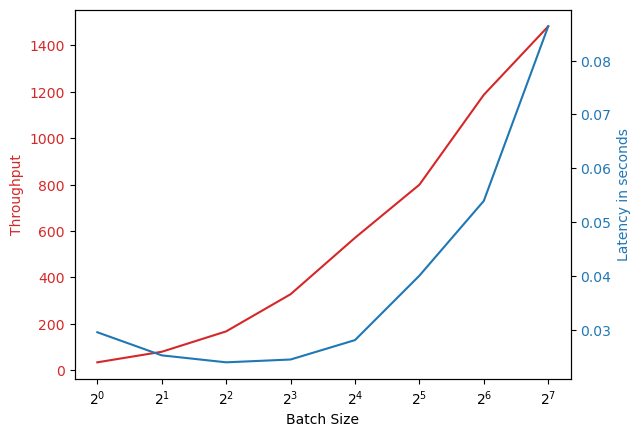

In [21]:
render_plot(
    batch_sizes,
    throughputs,
    latencies,
    "Batch Size",
    "Throughput",
    "Latency in seconds"
)